FileNotFoundError: [Errno 2] No such file or directory: '/Users/micha/Desktop/human_data_saveuser1.87585068940037e-309_2020_5_18-10_46_5/contWheel.png'

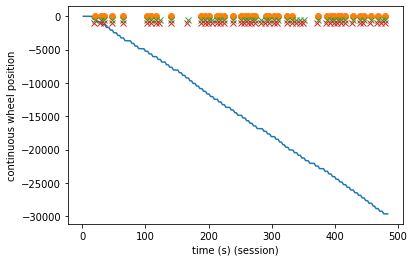

In [2]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

#%%
#Purpose of this script is to plot human behavioral data, (derived from sandboxSpyder.py, used for mouse analyses)

#%%
import os,sys,glob
import numpy as np
import pandas as pd
#import osfclient as osf
#from osfclient import cli
import h5py
import matplotlib.pyplot as plt

#local_storage = '/Users/elizabethstubblefield/Desktop/data/mouse_tunnel/data/'
local_storage = '/Users/micha/cheetah_or_elephant/data/'
session = 'user1.87585068940037e-309_2020_5_18-10_46_5' + '/'
#saveDir = '/Users/micha/Desktop/human_data_save' + session

######################################
#for sessions that don't need concatenation:
x = np.load(local_storage + session + 'x.npy')
t = np.load(local_storage + session + 't.npy')
v = (np.diff(x)*-1)/np.diff(t)  
rewardData = np.load(local_storage + session + 'rewardData.npy')  
#licks = np.load(local_storage + session +  'licks.npy')  


#For human data, licks are saved differently: 
lick1 = np.load(local_storage + session + 'rightKeyData.npy')
lick2 = np.load(local_storage + session + 'leftKeyData.npy')
licks = np.concatenate((lick1, lick2), axis = 0, out = None)

trialData = np.load(local_storage + session + 'trialData.npy')

#%% Plot continuous wheel position, trial start, licks, & rewards over session:

plt.plot(t,x)
plt.plot(rewardData,np.zeros(len(rewardData)),'o')
#  plt.plot(trialData,np.ones(len(trialData))*-10000,'x') #note trial data wasn't writing properly for mouse data up to 3.11.20
plt.plot(licks,np.ones(len(licks))*-500,'x')
plt.plot(trialData,np.ones(len(trialData))*-1000,'x')

plt.xlabel('time (s) (session)')
plt.ylabel('continuous wheel position')

#Wheel position in blue, trial start = orange x, licks = green x
plt.gcf().savefig(saveDir + 'contWheel.png',format='png',dpi=600)

#%%
plt.plot(t[:-1],v)                      #if NOT concatenated sessions, v will be 1 item shorter than t
plt.xlabel('time (s)')
plt.ylabel('wheel velocity')

plt.gcf().savefig(saveDir + 'wheel_velocity.png', format = 'png', dpi=600) 
    
#%%

#np.diff(t[1:100])  #diff in timestamps for first 100 events in time
selected_rewards = rewardData[np.argwhere(np.diff(rewardData) > 2).flatten()]   #diffs of reward timestamps > 2
selected_rewards.shape

approaches = []
ts=[]
lickset = []
rlickset=[]
treward = []
for i,rewardTime in enumerate(selected_rewards):
    reward_t = t[np.argwhere(t>rewardTime)[0][0]]
    treward.extend([t[np.argwhere(t>rewardTime)[0][0]-1]])                                                  #argwhere is synonymous to find; returns the index of values [0:end-1]
    approach = v[np.argwhere(t>rewardTime-10.)[0][0]:np.argwhere(t>rewardTime+6.)[0][0]]                    #find v where t>timestamp rew - 10s (x start) < +6s (lim of x axis)
    approach_t = t[np.argwhere(t>rewardTime-10.)[0][0]:np.argwhere(t>rewardTime+6.)[0][0]]                  #do the same for t
    licks  #ensure there are actually licks
#     licks_trial = licks[np.argwhere(licks>rewardTime-10.)[0][0]:np.argwhere(licks>rewardTime+6.)[0][0]]   #also licks   EAS: this can stand alone if licks
    if len(licks):  #EAS: otherwise...
#        rlicks_trial= licks[np.argwhere(licks<rewardTime)[-1][0]]
        licks_trial = licks[np.argwhere(licks>rewardTime-10.)[0][0]:np.argwhere(licks>rewardTime+6.)[0][0]] #also licks
        lickset.append(licks_trial)
        approaches.append(approach)
        ts.append(approach_t)
    else: 
        licks_trial = [0]
        approaches.append(approach)
        ts.append(approach_t)
  
#%%
#for i,a in enumerate(approaches): 
#    plt.plot(ts[i]-ts[i][0],a,color='k',alpha=0.1)                 #plot ea. trial's position w/ respect to reward
#    plt.xlabel('time (s) (aligned to approach & reward per trial)')
#    plt.ylabel('change in wheel position')
#    
#    plt.gcf().savefig(saveDir + 'diffx_approach.png',format='png',dpi=600)
        
#%%
from scipy.ndimage.filters import gaussian_filter1d

for i,a in enumerate(approaches): 
    plt.plot(ts[i]-ts[i][0],gaussian_filter1d(a,8),color='k',alpha=0.1)
    plt.xlabel('time (s) (aligned to approach & reward per trial)')
    plt.ylabel('change in wheel position (filtered)')
    
    plt.gcf().savefig(saveDir + 'diffx_approach_filt.png',format='png',dpi=600)
    
    #%%
import seaborn as sns
    
#Plot licks in chuncks based on trial #
lick_sync = list()
y1 = 0
y2 = list()
for i in range(0,len(selected_rewards)-1):                     #set up indices to be the proper length
        ndxA = np.argwhere(licks > selected_rewards[i])        #find where lick ts happened after rew ts
        ndxB = np.argwhere(licks < selected_rewards[i+1])      #find where lick ts happened before the next rew ts
        lick_sync.append(licks[np.intersect1d(ndxA,ndxB)])     #concatenate the two
        y2.append(y1)
        plt.plot(lick_sync[i], np.arange(y1,len(lick_sync[i])+y1), 'x')
        y1+=len(lick_sync[i])
    
#        plt.plot(selected_rewards[0:-1], y2, 'o')             #plot the selected rew times from 1st to the end-1 as 'o'
        plt.xlabel('time (s)')
        plt.ylabel('trial #')

plt.gcf().savefig(saveDir + 'licks_rew.png',format='png',dpi=600)
    
#%%
plt.figure(figsize=(4,3))
for i,a in enumerate(approaches): 
    plt.plot(ts[i]-treward[i],gaussian_filter1d(a,8),color='k',alpha=0.1)
    plt.plot(lickset[i]-treward[i],np.ones(len(lickset[i]))*i*-1,'o',ms=2,color='k',alpha=0.2)
    tl = lickset[i]-treward[i]
    rewarded_tl=tl[(tl > 0) & (tl < 1)]
    
    plt.plot(rewarded_tl,np.ones(len(rewarded_tl))*i*-1,'o',ms=2,color='b',alpha=1)
    plt.xlabel('time from end of images (sec)')
    plt.ylabel('running speed (mm/sec)')
    plt.yticks([0,25,50,75,100, 200, 300, 400])
plt.gcf().savefig(saveDir + 'summary_running_speed.png',format='png',dpi=600)

#%% 5 subplot layout (updated 5.12.20)
#NOTE for human data, a "lick" indicates arrow press/choice

#From matplotlib:
import matplotlib.gridspec as gridspec

#GridSpec(nrows, ncols[figure, left, bottom, right, top...])
#add_subplot(nrows, ncols, index, **kwargs)

#Set up the subplot layout:
f = plt.figure(figsize=(20, 10))

gs0 = gridspec.GridSpec(1, 1, figure=f)
gs00 = gridspec.GridSpecFromSubplotSpec(3, 3, subplot_spec=gs0[0])

ax1 = f.add_subplot(gs00[:, :-2])   #ax1 will be all rows & 1st col
ax2 = f.add_subplot(gs00[:,1])      #ax2 will be all rows & 2nd col    
ax3 = f.add_subplot(gs00[:-2, -1])  #ax3 will be row 1, col 3
ax4 = f.add_subplot(gs00[1, -1])    #ax4 will be row 2, col 3
ax5 = f.add_subplot(gs00[-1, 2])    #ax5 will be row 3, col 3


#First plot: align licks to trial start
treward2 = treward[1:]

trial_start = np.zeros(np.shape(trialData[:-1]),dtype='float64') #preallocate trial_start to be the same data type/shape as trialData
trial_start[:] = trialData[:-1]                                  #all vals of 1 = all vals of other
#trial_start[0] = 0                                              #the two vecs must start w/ diff vals to be different, moving forward

len_treward = len(treward)
cols1 = np.linspace(0,0.5,len(treward[0:]))                      #linspace(start, stop, #)
for i,j in enumerate(treward): 
    clr1 = [1*cols1[i],1*cols1[i],1*cols1[i]]
    lickset2 = lickset[0:len_treward]
    ax1.plot(lickset2[i]-trial_start[i],np.ones(len(lickset2[i]))*i*5,'o',ms=2,color='k')
#    ax1.plot(lickset[i]-trial_start[i], np.ones(len(lickset[i])))*i*5, 'o', ms = 2, color = 'k', alpha = 0.2)
    ax1.set_xlabel('licks, time from trial start (s)', fontsize = 10)
    ax1.set_ylabel('trial #', fontsize = 10)
    ax1.set_xlim(-10, 20, 5)


#Second plot: align licks to reward (note these are only rewarded trials on y axis)
cols = np.linspace(0,0.5,len(approaches))                        #linspace(start, stop, #)
for i,j in enumerate(approaches): 
    clr = [1*cols[i],1*cols[i],1*cols[i]]
    ax2.plot(lickset[i]-treward[i],np.ones(len(lickset[i]))*i*5,'o',ms=2,color='k')
    ax2.set_xlabel('licks, time from reward (s)', fontsize = 10)
    ax2.set_ylabel('rewarded trial #', fontsize = 10)
    ax2.set_xlim(-10, 20, 5)

    
#Third plot: performance over session
num_bins = 3  #Still working on binning - number of successive trials over which to average performance  

trial_aslist = trial_start.tolist()
logical_rewarded = np.zeros(np.shape(trial_start))                   #vector in which rewarded trial = 1; unrewarded = 0
rewarded_ndcs = list()
for u in treward:
    rewarded_ndcs.append(np.where(u > trial_aslist)[0][-1])
logical_rewarded[rewarded_ndcs] = 1

reward_ndx_from_trialstart = np.where(logical_rewarded)              #trial start indices that were rewarded
noreward_ndx_from_trialstart = np.where(np.abs(logical_rewarded-1))  #trial start indices that were not rewarded

x_vec = np.arange(0,len(trial_aslist))
ax3.plot(x_vec, logical_rewarded, 'o', color = 'k')
ax3.set_xlabel('trial #', fontsize = 10)
ax3.set_ylabel('performance', fontsize = 10)

#Fourth plot, wheel velocity:  
ax4.plot(t[:-1],v, color = 'k')    
ax4.set_xlabel('time (s)', fontsize = 10)
ax4.set_ylabel('wheel velocity', fontsize = 10)


f.subplots_adjust(top=0.95)
#plt.suptitle('4_22_20')
plt.suptitle(session)

plt.show()
f.savefig(saveDir + 'multAxes8.png',format='png',dpi=600)